# Explore protein sequences and structures

In [1]:
import torch
print(torch.__version__)
print(torch.version.cuda)

import boto3
import gzip
import numpy as np
import pandas as pd
from io import StringIO
from sklearn.metrics import pairwise_distances
from Bio import pairwise2
from Bio.Seq import Seq
from Bio.PDB.Polypeptide import three_to_one, is_aa
from Bio.PDB import MMCIFParser

1.10.0
11.1


In [2]:
# customer utils
# from contact_map_utils import gunzip_to_ram
# from prepare_GO_data import chain_to_coords
import sys
sys.path.append('lm-gvp')
from data.contact_map_utils import gunzip_to_ram
from data.prepare_GO_data import chain_to_coords

In [3]:
import matplotlib.pylab as plt
import seaborn as sns

## 1. Get a protein structure from PDB via AWS Opendata registry

https://registry.opendata.aws/pdb-3d-structural-biology-data/

In [4]:
pdb_id = '6XWU'
pdb_bucket_name = 'pdbsnapshots'

In [5]:
# retrieve and parse a protein structure from PDB
cif_parser = MMCIFParser()

s3 = boto3.resource('s3')
obj = s3.Object(
    pdb_bucket_name, 
    f'20220103/pub/pdb/data/structures/all/mmCIF/{pdb_id.lower()}.cif.gz'
)
pdb_file = obj.get()['Body']
structure = cif_parser.get_structure(pdb_id, gunzip_to_ram(pdb_file))

In [6]:
print(structure, type(structure))

<Structure id=6XWU> <class 'Bio.PDB.Structure.Structure'>


In [7]:
def extract_coords(structure, target_atoms=["N", "CA", "C", "O"]):
    '''
    Extract the atomic coordinates for all the chains.
    '''
    records = []
    chain_ids = set()
    for chain in structure.get_chains():
        if chain.id in chain_ids:  # skip duplicated chains
            continue
        chain_ids.add(chain.id)
        record = chain_to_coords(chain, 
                                 name=structure.id, 
                                 target_atoms=target_atoms)
        if record is not None:
            records.append(record)
    return records

In [8]:
records = extract_coords(structure)
# take the first chain from the structure
record = records[0]
print(record['seq'])
print('sequence length:', len(record['seq']))

DEQEEASTKLMQWLRGVGDAPPSASMSDENASVSSANELIFYQVDGIDYAFYNTKEKAMLGYMRFKPYQKRSMKQAKVHPLKLLVQFGEFNVETLAVGEEKEVHSVLRVGDMIEIDRGTRYSIQNAIDKVSVLMCIRS
sequence length: 138


In [9]:
coords = np.asarray(record['coords']) # 3d coordinates of 4 key atoms ["N", "CA", "C", "O"]
print(coords.shape)

(138, 4, 3)


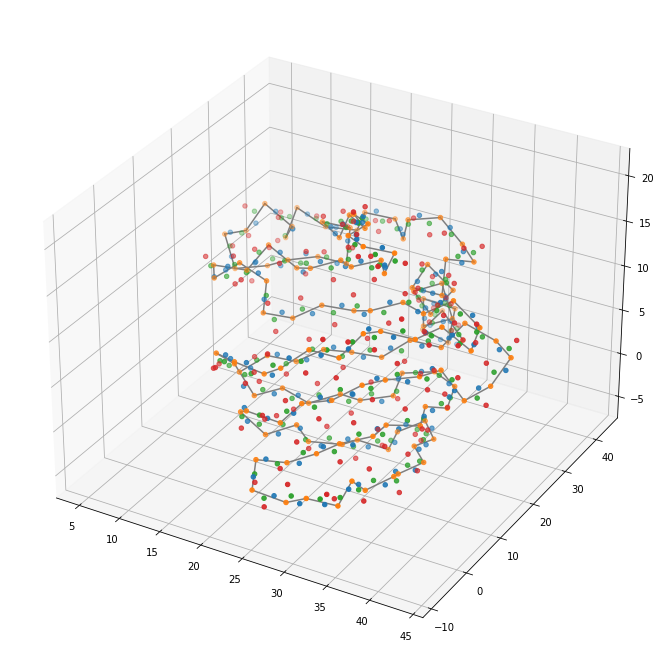

In [10]:
# Visualize 4 key atoms across amino acid residues in the protein
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

colors = sns.color_palette()
atoms = ["N", "CA", "C", "O"]
for i, atom in enumerate(atoms):
    ax.scatter(coords[:, i, 0],
               coords[:, i, 1],
               coords[:, i, 2],
               color=colors[i]
              );
    
# connect CA atoms sequentially
coords_CA = coords[:, 1]
N_residues = coords.shape[0]
edge_pos = np.array([(coords_CA[u], coords_CA[u+1]) for u in range(N_residues-1)])

# Plot the edges
for vizedge in edge_pos:
    ax.plot(*vizedge.T, color="tab:gray")

(138, 138)


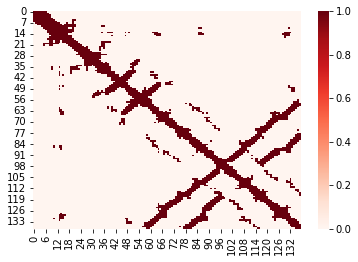

In [11]:
# Visualize as contact map
# calculate adjacency matrix of residues by proximity threshod
dist_thresh = 10.0
dist_mat = pairwise_distances(coords_CA, metric="euclidean")
adj =  1 * (dist_mat < dist_thresh)
print(adj.shape)
sns.heatmap(adj, cmap='Reds');

## 2. Compute contextual embeddings for protein sequence from pretrained protein language model

In [18]:
from transformers import AlbertModel, BertTokenizer

In [19]:
# tokenizer = AlbertTokenizer.from_pretrained('Rostlab/prot_albert', do_lower_case=False)
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
prot_lm = AlbertModel.from_pretrained('Rostlab/prot_albert')

Some weights of the model checkpoint at Rostlab/prot_albert were not used when initializing AlbertModel: ['sop_classifier.classifier.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.bias', 'predictions.dense.weight', 'sop_classifier.classifier.weight', 'predictions.decoder.weight', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
import re
def prep_seq(seq):
    """
    Adding spaces between AAs and replace rare AA [UZOB] to X.
    ref: https://huggingface.co/Rostlab/prot_bert.

    Args
        seq: a string of AA sequence.

    Returns:
        String representing the input sequence where U,Z,O and B has been replaced by X.
    """
    seq_spaced = " ".join(seq)
    seq_input = re.sub(r"[UZOB]", "X", seq_spaced)
    return seq_input


In [21]:
encodings = tokenizer(prep_seq(record['seq']), 
                      return_tensors="pt", 
                      padding=True)
encodings

{'input_ids': tensor([[ 2, 14,  9, 18,  9,  9,  6, 10, 15, 12,  5, 21, 18, 24,  5, 13,  7,  8,
          7, 14,  6, 16, 16, 10,  6, 10, 21, 10, 14,  9, 17,  6, 10,  8, 10, 10,
          6, 17,  9,  5, 11, 19, 20, 18,  8, 14,  7, 11, 14, 20,  6, 19, 20, 17,
         15, 12,  9, 12,  6, 21,  5,  7, 20, 21, 13, 19, 12, 16, 20, 18, 12, 13,
         10, 21, 12, 18,  6, 12,  8, 22, 16,  5, 12,  5,  5,  8, 18, 19,  7,  9,
         19, 17,  8,  9, 15,  5,  6,  8,  7,  9,  9, 12,  9,  8, 22, 10,  8,  5,
         13,  8,  7, 14, 21, 11,  9, 11, 14, 13,  7, 15, 13, 20, 10, 11, 18, 17,
          6, 11, 14, 12,  8, 10,  8,  5, 21, 23, 11, 13, 10,  3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         

In [22]:
device = torch.device('cuda:0')
prot_lm = prot_lm.to(device)

In [23]:
prot_lm.eval()

AlbertModel(
  (embeddings): AlbertEmbeddings(
    (word_embeddings): Embedding(34, 128, padding_idx=0)
    (position_embeddings): Embedding(40000, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder): AlbertTransformer(
    (embedding_hidden_mapping_in): Linear(in_features=128, out_features=4096, bias=True)
    (albert_layer_groups): ModuleList(
      (0): AlbertLayerGroup(
        (albert_layers): ModuleList(
          (0): AlbertLayer(
            (full_layer_layer_norm): LayerNorm((4096,), eps=1e-12, elementwise_affine=True)
            (attention): AlbertAttention(
              (query): Linear(in_features=4096, out_features=4096, bias=True)
              (key): Linear(in_features=4096, out_features=4096, bias=True)
              (value): Linear(in_features=4096, out_features=4096, bias=True)
              (attention_dropout): Dropout(p=0, inplace=False)

In [24]:
# skip [CLS] and [SEP]
residue_embeddings = prot_lm(encodings['input_ids'].to(device))\
    .last_hidden_state[:, 1:-1, :]
print(residue_embeddings.shape)

torch.Size([1, 138, 4096])
